In [1]:
base_dir = 'datasets/cats_and_dogs'

In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
from keras.layers import *
from keras.models import *

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [4]:
print('weight count before conv_base freezing: ', len(model.trainable_weights))
conv_base.trainable = False
print('weight count after conv_base freezing: ', len(model.trainable_weights))
model.summary()

weight count before conv_base freezing:  30
weight count after conv_base freezing:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
import os
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

val_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [8]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_generator,
    validation_steps=50
).history

Epoch 1/30
100/100 [==============================] - 17s 168ms/step - loss: 0.5682 - acc: 0.7190 - val_loss: 0.4277 - val_acc: 0.8270
Epoch 2/30
100/100 [==============================] - 15s 147ms/step - loss: 0.4754 - acc: 0.7830 - val_loss: 0.3551 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 16s 155ms/step - loss: 0.4312 - acc: 0.7945 - val_loss: 0.3225 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 15s 150ms/step - loss: 0.4024 - acc: 0.8260 - val_loss: 0.3053 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 15s 152ms/step - loss: 0.3734 - acc: 0.8425 - val_loss: 0.2927 - val_acc: 0.8730
Epoch 6/30
100/100 [==============================] - 15s 146ms/step - loss: 0.3678 - acc: 0.8335 - val_loss: 0.2830 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 15s 146ms/step - loss: 0.3630 - acc: 0.8370 - val_loss: 0.2721 - val_acc: 0.8880
Epoch 8/30
100/100 [==============================] - 1

In [9]:
import matplotlib.pyplot as plt
def plot(history, smooth_enabled = False):
    epoch = range(1, len(history['acc']) + 1)
    plt.clf()
    target = smooth_curve(history['acc']) if smooth_enabled else history['acc']
    plt.plot(epoch, target, 'bo', label='Training Acc')
    target = smooth_curve(history['loss']) if smooth_enabled else history['loss']
    plt.plot(epoch, target, 'bP', label='Training Loss')
    target = smooth_curve(history['val_acc']) if smooth_enabled else history['val_acc']
    plt.plot(epoch, target, 'ro', label='Validation Acc')
    target = smooth_curve(history['val_loss']) if smooth_enabled else history['val_loss']
    plt.plot(epoch, target, 'rP', label='Validation Loss')
    plt.legend()
    plt.show()

In [10]:
def smooth_curve(points, factor = 0.8):
    smoothed = []
    for p in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + p + (1 - factor))
        else:
            smoothed.append(p)
    return smoothed

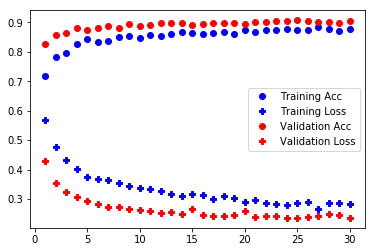

In [12]:
plot(history)

In [13]:
score = model.evaluate_generator(test_generator, 50)

In [14]:
print("Loss : ", score[0], "\tACC : ", score[1])

Loss :  0.24475754782557488 	ACC :  0.8949999988079071


In [16]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
len(model.trainable_weights)

10

In [17]:
model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-5), metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
    validation_steps=50
).history

Epoch 1/100
100/100 [==============================] - 17s 167ms/step - loss: 0.2791 - acc: 0.8800 - val_loss: 0.2316 - val_acc: 0.9050
Epoch 2/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2628 - acc: 0.8910 - val_loss: 0.2349 - val_acc: 0.9170
Epoch 3/100
100/100 [==============================] - 15s 150ms/step - loss: 0.2451 - acc: 0.8945 - val_loss: 0.1881 - val_acc: 0.9280
Epoch 4/100
100/100 [==============================] - 15s 148ms/step - loss: 0.2192 - acc: 0.9035 - val_loss: 0.2094 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 15s 150ms/step - loss: 0.2074 - acc: 0.9090 - val_loss: 0.1917 - val_acc: 0.9260
Epoch 6/100
100/100 [==============================] - 15s 152ms/step - loss: 0.1974 - acc: 0.9195 - val_loss: 0.2571 - val_acc: 0.8970
Epoch 7/100
100/100 [==============================] - 15s 150ms/step - loss: 0.1775 - acc: 0.9255 - val_loss: 0.1912 - val_acc: 0.9250
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 15s 151ms/step - loss: 0.0375 - acc: 0.9875 - val_loss: 0.2072 - val_acc: 0.9390
Epoch 62/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0337 - acc: 0.9875 - val_loss: 0.2443 - val_acc: 0.9400
Epoch 63/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0381 - acc: 0.9865 - val_loss: 0.3094 - val_acc: 0.9210
Epoch 64/100
100/100 [==============================] - 15s 151ms/step - loss: 0.0213 - acc: 0.9925 - val_loss: 0.3258 - val_acc: 0.9270
Epoch 65/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0304 - acc: 0.9890 - val_loss: 0.3159 - val_acc: 0.9280
Epoch 66/100
100/100 [==============================] - 15s 151ms/step - loss: 0.0305 - acc: 0.9900 - val_loss: 0.2318 - val_acc: 0.9450
Epoch 67/100
100/100 [==============================] - 15s 152ms/step - loss: 0.0254 - acc: 0.9925 - val_loss: 0.2248 - val_acc: 0.9380
Epoch 68/100
100/100 [===================

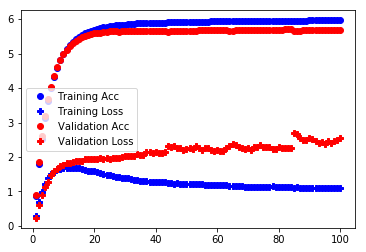

In [18]:
plot(history, True)

In [19]:
fine_tuned_score = model.evaluate_generator(test_generator, 50)
print("Loss : ", fine_tuned_score[0], "\tAcc : ", fine_tuned_score[1])

Loss :  0.417230763384141 	Acc :  0.9289999914169311


In [20]:
model.save('retrain_convnet_fine_tuning.h5')